# Processing STAC Assets using Dask  

We open a STAC catalog stored on dCache:

In [1]:
import fsspec
import stac2dcache  

from pystac import Catalog

In [2]:
# configure STAC I/O from/to dCache using full http URLs
fs = fsspec.get_filesystem_class("dcache")()
stac_io = stac2dcache.configure_stac_io(filesystem=fs)

In [3]:
# read catalog from storage
catalog_url = 'https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/tmp-sentinel-2-catalog/catalog.json'

catalog = Catalog.from_file(catalog_url, stac_io=stac_io)
catalog.make_all_asset_hrefs_absolute()  # required by stackstac
catalog.describe()

* <Catalog id=s2-catalog>
  * <Item id=S2B_5VNK_20180325_1_L2A>
  * <Item id=S2A_5VNK_20180324_0_L2A>
  * <Item id=S2B_5VNK_20180322_0_L2A>
  * <Item id=S2B_5VNK_20180319_0_L2A>


We open the STAC catalog as a [Xarray](http://xarray.pydata.org/en/stable/) `DataArray` object using [`stackstac`](https://stackstac.readthedocs.io). `stackstac` uses `GDAL` to open and read (remote) geospatial files, with authentication set up via a headers file:

In [4]:
import os
import rioxarray
import stackstac

In [5]:
headers_filepath = "./gdal_http_header_file.txt"
with open(headers_filepath, "w") as f:
    for k, v in fs.client_kwargs["headers"].items():
        f.write(f"{k}: {v}\n")

In [6]:
env = stackstac.DEFAULT_GDAL_ENV.updated(
    {"GDAL_HTTP_HEADER_FILE": os.path.abspath(headers_filepath)}
)

We setup some "lazy" computations:

In [7]:
da = stackstac.stack(catalog, resolution=60, gdal_env=env)
da

,Array,Chunk
Bytes,1.70 GiB,8.00 MiB
Shape,"(4, 17, 1830, 1830)","(1, 1, 1024, 1024)"
Count,408 Tasks,272 Chunks
Type,float64,numpy.ndarray


We setup some simple manipulation: we select the 'B-1' band of all scenes (retrieved to dCache in the previous notebook) and calculate the median over all scenes: 

In [8]:
b01 = da.sel(band="B01")
b01

<xarray.DataArray 'stackstac-8a9429d710c32553598cb32f440bb141' (time: 4,
                                                                y: 1830, x: 1830)>
dask.array<getitem, shape=(4, 1830, 1830), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                        (time) datetime64[ns] 2018-03-19T21:35:22 ......
    id                          (time) <U23 'S2B_5VNK_20180319_0_L2A' ... 'S2...
    band                        <U8 'B01'
  * x                           (x) float64 5e+05 5e+05 ... 6.097e+05 6.097e+05
  * y                           (y) float64 7e+06 7e+06 ... 6.89e+06 6.89e+06
    view:off_nadir              int64 0
    ...                          ...
    instruments                 <U3 'msi'
    title                       <U31 'Band 1 (coastal)'
    common_name                 object 'coastal'
    center_wavelength           object 0.4439
    full_width_half_max         object 0.027
    epsg                        int64 32605
Attributes:
    spec:        RasterSpec(epsg=32605, bounds=(499980, 6890220, 609780, 7000...
    crs:         epsg:32605
    transform:   | 60.00, 0.00, 499980.00|\n| 0.00,-60.00, 7000020.00|\n| 0.0...
    resolution:  60

In [9]:
median = b01.median(dim="time")
median

<xarray.DataArray 'stackstac-8a9429d710c32553598cb32f440bb141' (y: 1830, x: 1830)>
dask.array<nanmedian, shape=(1830, 1830), dtype=float64, chunksize=(1830, 1830), chunktype=numpy.ndarray>
Coordinates: (12/16)
    band                    <U8 'B01'
  * x                       (x) float64 5e+05 5e+05 ... 6.097e+05 6.097e+05
  * y                       (y) float64 7e+06 7e+06 7e+06 ... 6.89e+06 6.89e+06
    view:off_nadir          int64 0
    sentinel:utm_zone       int64 5
    gsd                     object 60
    ...                      ...
    instruments             <U3 'msi'
    title                   <U31 'Band 1 (coastal)'
    common_name             object 'coastal'
    center_wavelength       object 0.4439
    full_width_half_max     object 0.027
    epsg                    int64 32605

We now submit the actual calculation to the Dask cluster. In the side menu, from the Dask tab, we can select the running cluster and add workers using the `scale` button. We can then drag or copy/paste the lines to create a client connection to the cluster in the notebook:

In [10]:
from dask.distributed import Client

client = Client("tcp://10.0.0.226:33645")
client

<Client: 'tcp://10.0.0.226:33645' processes=3 threads=12, memory=90.00 GiB>

Calculation is triggered by calling the `compute` method:

In [11]:
# execute tasks and pull data from workers
median = median.compute()
median 

<xarray.DataArray 'stackstac-8a9429d710c32553598cb32f440bb141' (y: 1830, x: 1830)>
array([[ 3677. ,  3601.5,  4432. , ...,  4806. ,  5293. ,  4292. ],
       [ 4342.5,  4472. ,  6822.5, ...,  6587. ,  6828. ,  5825. ],
       [ 6307.5,  6340.5,  7968. , ...,  6699. ,  6655. ,  5496. ],
       ...,
       [ 9449. , 10785. , 10272.5, ...,  1733. ,  2269. ,  1933. ],
       [ 9722.5, 11213.5, 11077. , ...,  1799. ,  2759. ,  2406. ],
       [ 8700.5, 10067. ,  9862. , ...,  1220. ,  1634. ,  1917. ]])
Coordinates: (12/16)
    band                    <U8 'B01'
  * x                       (x) float64 5e+05 5e+05 ... 6.097e+05 6.097e+05
  * y                       (y) float64 7e+06 7e+06 7e+06 ... 6.89e+06 6.89e+06
    view:off_nadir          int64 0
    sentinel:utm_zone       int64 5
    gsd                     object 60
    ...                      ...
    instruments             <U3 'msi'
    title                   <U31 'Band 1 (coastal)'
    common_name             object 'coastal'
    center_wavelength       object 0.4439
    full_width_half_max     object 0.027
    epsg                    int64 32605

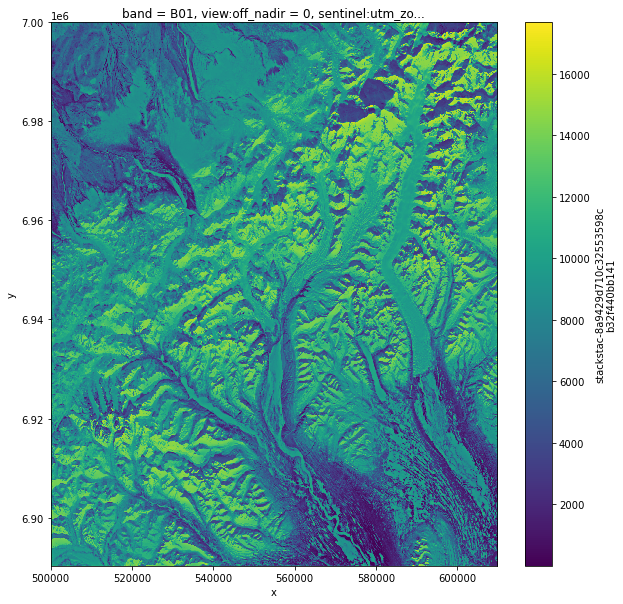

In [12]:
# plot results
median.plot.imshow(figsize=(10,10))

In [13]:
# save outcome to file locally
median.rio.to_raster("median.tif")